## Data extraction

In [1]:
%load_ext autoreload
%autoreload 2
#plt.rcParams['figure.figsize'] = (16,8)

In [75]:
import pandas as pd
import os

path = 'U:\\Projects\\datasets\\customer_history\\selection_26-02-2020'
os.chdir(path)

In [78]:
test = pd.read_excel('test_CZ.xlsx', header = 1)

In [79]:
test

,Unnamed: 0,Customer Salesforce ID,Date,Receipt ID
0,NaN,0031i000001ra4nAAA,2018-12-03,1444822939
1,NaN,0031i000001ra4nAAA,2018-12-13,1451264086
2,NaN,0031i000001ra4nAAA,2019-01-04,1750314844
3,NaN,0031i000001ra4nAAA,2019-03-24,1756336696
4,NaN,0031i000001ra4nAAA,2019-08-21,1766447083
...,...,...,...,...
113771,NaN,0031i000004KTjzAAG,2019-02-05,1751014300
113772,NaN,0031i000004KTjzAAG,2019-06-28,1763182542
113773,NaN,0031i000004KTjzAAG,2019-09-23,1768885665
113774,NaN,0031i000004KTk6AAG,2019-02-05,1751270987


In [80]:
test.loc[test['Customer Salesforce ID'] == '0035800001OnOnEAAV']

,Unnamed: 0,Customer Salesforce ID,Date,Receipt ID


In [3]:
df_club = pd.read_csv('customer_buying_history_15-02-2018_15-02-2020.csv', 
                 engine='python',
                 error_bad_lines=False,
                 decimal = ',')

Skipping line 6176115: unexpected end of data


In [9]:
df_etmp = pd.read_csv('customer_buying_history_ECom_15-02-2018_15-02-2020.csv', 
                 engine='python',
                 error_bad_lines=False,
                 decimal = ',')

In [27]:
# Import keys linking mails and SFID
os.chdir('U:\\Projects\\datasets\\mails\\main_data')
df_keys = pd.read_csv('daily_segment_NL_data_JHL_20200220.csv',
                      sep=';',
                      encoding='utf-16',
                      #usecols=["SubscriberKey", "Email"]
                     )
# Select these customers that have a valid email from ECom NonClub
df_ecom = df_etmp.merge(df_keys, on= 'Email', how='inner').rename(columns = {'SubscriberKey': 'sfid'})
lost_cust = df_etmp.shape[0] - df_ecom.shape[0]
print(str(lost_cust)+' lost ECom non Club customers based on Email merge')
print('i.e., '+str((lost_cust / df_etmp.shape[0])*100)+'% lost ECom customers.')

4739536 lost ECom non Club customers based on Email merge
i.e., 60.07289050631195% lost ECom customers.


In [81]:
df_keys

,SubscriberKey,Email
0,0031i000001ra07AAA,lavy24vidu@yahoo.it
1,0031i000001ra60AAA,andrewcars80@gmail.com
2,0031i000001ra8PAAQ,j.praum@gmx.de
3,0031i000001raazAAA,karin.demuth@patrick-goehler-holding.de
4,0031i000001raaZAAQ,gbezina13@gmail.com
...,...,...
2434554,0035800001Z0ZRNAA3,mihaela.mlakar1@gmail.com
2434555,0035800001Z0ZRRAA3,sarahmohren@web.de
2434556,0035800001Z0ZRrAAN,agnryd1312@gmail.com
2434557,0035800001Z0ZRXAA3,lisa_bucher@gmx.at


In [28]:
def run_dat_extract():


    from purchase_prediction.munging_pipeline import (start_pipeline, 
                                                      select_valid_cards, 
                                                      lower_cols, 
                                                      def_types, 
                                                      down_sample,
                                                      correct_timestamps, 
                                                      correct_for_retourned,
                                                      drop_retours,
                                                      assign_customer_type
                                                     )

    from purchase_prediction.munging_pipeline_ecom import (rename_cols_ecom,
                                                           correct_timestamps_ecom,
                                                           def_types_ecom,
                                                           drop_cols
                                                           )

    df_club_clean = (df_club
    .pipe(start_pipeline)
    .pipe(select_valid_cards)
    .pipe(lower_cols)            
    .pipe(correct_timestamps)
    .pipe(def_types)
    #.pipe(down_sample, threshold=50000)
    #.pipe(correct_for_retourned) # This steps is very long (should be optimized). Only use if monetary value required.
    .pipe(drop_retours)   
    .pipe(assign_customer_type,label='club')
    )

    print('')
    print('There are ' + str(df_club_clean.groupby(by='customer_salesforce_id').count().shape[0]) + ' club customers.')

    # df_club_clean.head(1)

    df_ecom_clean = (df_ecom
    .pipe(start_pipeline)
    .pipe(rename_cols_ecom)
    .pipe(correct_timestamps_ecom)            
    .pipe(def_types_ecom)
    .pipe(drop_cols)   
    .pipe(assign_customer_type, label='ecom_nonclub')
    )

    print('There are ' + str(df_ecom_clean.groupby(by='eshop_id').count().shape[0]) + ' Ecom non club customers.')
    print('')

    #return df_club_clean, df_ecom_clean
    # df_ecom_clean.head(1)

    from purchase_prediction.ml_pipeline import (select_recent_members, 
                                                 date_benchmarking, 
                                                 compute_age_recency, 
                                                 rename_cols, 
                                                 select_ml_data, 
                                             )

    from purchase_prediction.ml_pipeline_ecom import (select_receipt_dates_ecom, 
                                                      compute_age_recency_ecom, 
                                                      rename_cols_ecom_ml, 
                                                      add_frequency, 
                                                      select_ml_data_ecom, 
                                                 )
    now_time_reference = '2020-01-01T00'
    df_club_ml = (df_club_clean
    .pipe(start_pipeline)
#     .pipe(select_recent_members,
#     timestamp_bef='2018-01-01T00',
#     timestamp_aft=now_time_reference,
#     action = "between")
#    .pipe(date_benchmarking, upper_benchmark=now_time_reference)
    .pipe(compute_age_recency,timestamp_ref=now_time_reference)
    .pipe(rename_cols)
    .pipe(select_ml_data)
    )

    lost_customers = df_club_clean.groupby(by='club_card_number').count().shape[0] - df_club_ml.groupby(by='club_card_number').count().shape[0]
    print('Data cleansing yields ' + str(lost_customers) + ' lost customers.')
    print('#Customers select for ML pipeline = ' + str(df_club_ml.groupby(by='club_card_number').count().shape[0]))

    df_ecom_ml = (df_ecom_clean
    .pipe(select_receipt_dates_ecom, upper_benchmark=now_time_reference)
    .pipe(compute_age_recency_ecom,timestamp_ref=now_time_reference)
    .pipe(rename_cols_ecom_ml)
    .pipe(add_frequency)
    .pipe(select_ml_data_ecom)              
         )

    lost_customers = df_ecom_clean.groupby(by='sfid').count().shape[0] - df_ecom_ml.groupby(by='sfid').count().shape[0]
    print('Data cleansing yields ' + str(lost_customers) + ' lost customers.')
    print('#Customers select for Ecom ML pipeline = ' + str(df_ecom_ml.groupby(by='club_card_number').count().shape[0]))

    # POOLING CLUB & ECOM
    df_ml = (pd.concat([df_club_ml, df_ecom_ml], axis=0, join='outer', sort=False)
    .dropna() # Some customers have missing SFID
    )
    print(df_ml.head(5))
    return df_ml

## Model fit & test

In [12]:
def run_model(df_ml):
    # Import models
    from lifetimes import BetaGeoFitter,ParetoNBDFitter
    bgf = BetaGeoFitter(penalizer_coef=0.001)
    #bgf_Pareto = ParetoNBDFitter(penalizer_coef=0.1)

    # Verify that the model is doing a relatively good job at predicting values
    from lifetimes.utils import calibration_and_holdout_data
    # This function creates a summary of each customer over a calibration and holdout period (training and testing)
    # It accepts transaction data, and returns a DataFrame of sufficient statistics.
    summary_cal_holdout = calibration_and_holdout_data(df_ml, 'sfid', 'receipt_issue_date',
                                                        calibration_period_end='2018-10-01',
                                                        observation_period_end='2019-10-01',
                                                        freq='W',
                                                        monetary_value_col = 'monetary_value')

    from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases

    bgf.fit(summary_cal_holdout['frequency_cal'], 
            summary_cal_holdout['recency_cal'], 
            summary_cal_holdout['T_cal'])
    plot_calibration_purchases_vs_holdout_purchases(bgf, summary_cal_holdout)

    # Model summary
    print('Model Summary')
    print(bgf.summary)

    ## Model fit over all data to predict 2020

    # Transform transaction data into customer-based data with three attributes
    from lifetimes.utils import summary_data_from_transaction_data

    summary = summary_data_from_transaction_data(df_ml, 
                                                 'sfid', 
                                                 'receipt_issue_date', 
                                                 observation_period_end='2019-10-01',
                                                 datetime_format = '%Y-%m-%d',
                                                 freq='W',
                                                 monetary_value_col = 'monetary_value')
    print('Sample of ML data')
    print(summary.sample(2))
    print('')

    from lifetimes import BetaGeoFitter

    # similar API to scikit-learn and lifelines.
    # I am using some penalizer due to low sample size, see lifetimes documentation.
    bgf = BetaGeoFitter(penalizer_coef=0.001)
    bgf.fit(summary['frequency'], summary['recency'], summary['T'])
    print(bgf.summary)

    # Add predicted purchases to summary dataframe
    # Predicted purchases are calculated for a given time window t
    t = 4
    summary['pred_purch_coming_week=' + str(t)] = (bgf.conditional_expected_number_of_purchases_up_to_time
                                                   (
                                                    t, 
                                                    summary['frequency'], 
                                                    summary['recency'], 
                                                    summary['T']
                                                   )
                                                  )

    from lifetimes.plotting import plot_period_transactions
    plot_period_transactions(bgf)
    return summary

## Run the good stuff

In [30]:
#_set_params
path = 'u:\\Projects\\datasets\\customer_history\\spring_special_2020'
# path = 'u:\\Projects\\datasets\\customer_history\\winter_celebration'
# country = 'DE'
# extract data
df_ml = run_dat_extract()

f/ select_valid_cards cleaned: 767 (i.e., 0.01% of initial data) entries from input dataf.

There are 1102574 club customers.
There are 830745 Ecom non club customers.

Data cleansing yields 0 lost customers.
#Customers select for ML pipeline = 1124983
Data cleansing yields 31351 lost customers.
#Customers select for Ecom ML pipeline = 781937
                   sfid  club_card_number  age_in_weeks  recency_in_weeks  \
767  0035800001GTTe8AAH           12347.0    537.857143        525.857143   
769  0035800001GTTe8AAH           12347.0    537.857143        525.857143   
770  0035800001GTTe8AAH           12347.0    537.857143        525.857143   
771  0035800001GTTe8AAH           12347.0    537.857143        525.857143   
772  0035800001GTTe8AAH           12347.0    537.857143        525.857143   

     frequency  monetary_value   receipt_issue_date customer_type  
767        1.0       27.481884  2018/04/24 00:00:00          club  
769        1.0       46.409693  2018/05/30 00:00:00     

C:\Users\jhernandez-lallement\AppData\Local\Continuum\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in log
  return f_raw(*args, **kwargs)


Model Summary
            coef  se(coef)  lower 95% bound  upper 95% bound
r       0.672790  0.002182         0.668513         0.677067
alpha  10.351871  0.042151        10.269255        10.434486
a       0.051060  0.001506         0.048108         0.054012
b       0.510203  0.013568         0.483610         0.536796
Sample of ML data
                    frequency  recency     T  monetary_value
sfid                                                        
0031i000004o2neAAA        1.0     13.0  33.0           12.99
0035800000HMJCPAA5        0.0      0.0  49.0            0.00

            coef  se(coef)  lower 95% bound  upper 95% bound
r       0.606783  0.001054         0.604718         0.608848
alpha  11.842459  0.026278        11.790955        11.893964
a       0.060782  0.000609         0.059589         0.061975
b       0.772107  0.008535         0.755379         0.788836


C:\Users\jhernandez-lallement\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\series.py:856: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


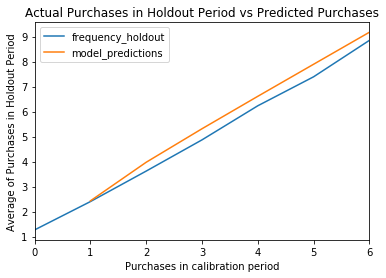

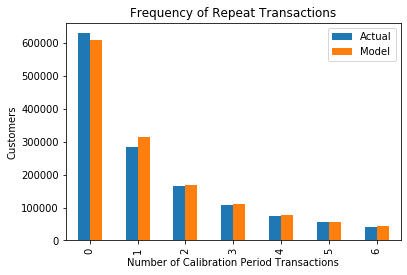

In [31]:
# run model
summary = run_model(df_ml=df_ml)

In [63]:
import os
import pandas as pd
path = 'U:\\Projects\\datasets\\customer_history\\selection_26-02-2020'
os.chdir(path)
to_score = pd.read_csv('Spring_Special_2020_ALL_IN_NL_20200224.csv', usecols=['ContactId', 'Country'])

In [64]:
test = pd.merge(to_score,summary, left_on='ContactId', right_on='sfid', how='left')

In [65]:
test

,ContactId,Country,sfid,frequency,recency,T,monetary_value,pred_purch_coming_week=4
0,0035800000yLBgNAAW,IT,NaN,NaN,NaN,NaN,NaN,NaN
1,0035800000yLBhVAAW,AT,NaN,NaN,NaN,NaN,NaN,NaN
2,0035800000yLBhfAAG,AT,NaN,NaN,NaN,NaN,NaN,NaN
3,0035800000yLBk7AAG,AT,NaN,NaN,NaN,NaN,NaN,NaN
4,0035800000yrj2MAAQ,HU,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
1599747,0035800001OnOnEAAV,SK,NaN,NaN,NaN,NaN,NaN,NaN
1599748,0035800001OnOnGAAV,SK,NaN,NaN,NaN,NaN,NaN,NaN
1599749,0035800001OnOqgAAF,SK,0035800001OnOqgAAF,0.0,0.0,45.0,0.0,0.042529
1599750,0035800001OnOqiAAF,SK,NaN,NaN,NaN,NaN,NaN,NaN


## Comparison DeFacto

In [34]:
summary = summary.reset_index()
summary.loc[summary.sfid == '0035800001Ix4GyAAJ']

,sfid,frequency,recency,T,monetary_value,pred_purch_coming_week=4
1255513,0035800001Ix4GyAAJ,54.0,78.0,78.0,85.938658,2.425199


We loose 79742 customers with DeFacto merging
Correlation coefficients between DeFacto and Orsay scoring:
index                       0.022266
frequency                   0.639133
recency                     0.460352
T                           0.104500
monetary_value              0.219758
pred_purch_coming_week=4    0.674896
norm_purchase               0.674896
score                       1.000000
Name: score, dtype: float64


C:\Users\jhernandez-lallement\AppData\Local\Continuum\anaconda3\lib\site-packages\plotnine\layer.py:452: PlotnineWarning: geom_point : Removed 14382 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


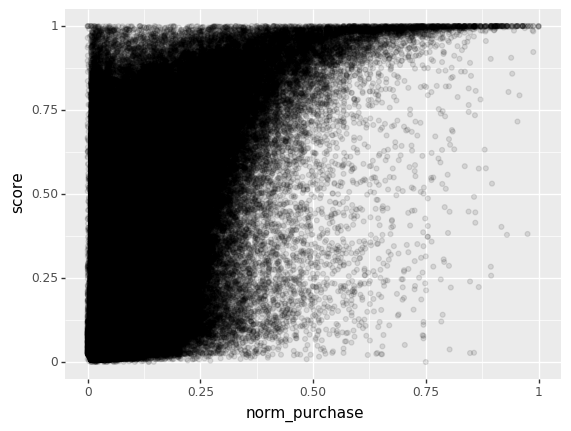

<ggplot: (-9223371897222816424)>

In [47]:
import os
import plotnine as p9
import pandas as pd

def normalize(df):
    result = df.copy()
    #for feature_name in df.columns:
    result = result.values
    max_value = df.max()
    min_value = df.min()
    result = (df - min_value) / (max_value - min_value)
    return result

path = 'u:\\Projects\\datasets\\customer_history\\DeFacto_scores'
file = 'Orsay_Promo_salesforce_January_2020.csv' # PreSale January 2020
#file = '20190913_Score_Winter_Celebration.csv'   # Winter Celebration October 2019
#file = '20191025_Winter_Presale_Daten_Score.csv' # Winter PreSale November 2019
os.chdir(path)
os.getcwd()

## Import data
files = os.listdir()
df_defacto = pd.read_csv(files[files.index(file)],sep=';', 
                          header = 0,
                          decimal=",")
df_defacto.columns = [c.lower() for c in df_defacto.columns]

df_orsay = summary.copy()
df_orsay = df_orsay.assign(norm_purchase = lambda d: normalize(d['pred_purch_coming_week=4']))
df_orsay.reset_index(level=0, inplace=True)

merged_orsay_defacto_data = df_orsay.merge(df_defacto, on='sfid', how='inner')
print('We loose ' + str(df_orsay.shape[0] - merged_orsay_defacto_data.shape[0]) + ' customers with DeFacto merging')



print('Correlation coefficients between DeFacto and Orsay scoring:')
print(merged_orsay_defacto_data.corr()['score'])

(p9.ggplot(mapping=p9.aes(x='norm_purchase', y='score'), data=merged_orsay_defacto_data)
+ p9.geom_point(alpha=0.1))

In [61]:
(merged_orsay_defacto_data.loc[(merged_orsay_defacto_data.norm_purchase < 0.5) & (merged_orsay_defacto_data.score > 0.5)]
.sort_values(by='norm_purchase', ascending=True)
)

,index,sfid,frequency,recency,T,monetary_value,pred_purch_coming_week=4,norm_purchase,scoringidentifier,score
1332440,1407138,0035800001SkeTBAAZ,26.0,33.0,84.0,0.246269,7.862701e-07,2.095012e-07,Spring Special 2020,0.896306
925763,978801,0035800000ycwW6AAI,21.0,36.0,85.0,17.723135,7.354819e-05,2.082793e-05,Spring Special 2020,0.936061
826913,879436,0035800000lSq87AAC,20.0,33.0,79.0,137.944500,1.417003e-04,4.014009e-05,Spring Special 2020,0.611608
881599,934468,0035800000xzGiuAAE,18.0,24.0,66.0,48.862833,1.508706e-04,4.273867e-05,Spring Special 2020,0.998645
1186773,1256652,0035800001IxaeLAAR,32.0,44.0,77.0,82.693210,2.037071e-04,5.771086e-05,Spring Special 2020,0.508524
...,...,...,...,...,...,...,...,...,...,...
539647,590329,0035800000HQVLFAA5,40.0,80.0,80.0,60.551409,1.763497e+00,4.997193e-01,Spring Special 2020,0.778461
824098,876615,0035800000kqHh7AAE,40.0,80.0,80.0,118.072233,1.763497e+00,4.997193e-01,Spring Special 2020,0.907648
1056960,1122751,003580000193yDIAAY,40.0,80.0,80.0,38.610607,1.763497e+00,4.997193e-01,Spring Special 2020,0.938187
510867,561509,0035800000HPpaRAAT,40.0,80.0,80.0,29.885959,1.763497e+00,4.997193e-01,Spring Special 2020,0.829414


# CLV

In [42]:
returning_customers_summary = summary.copy()
returning_customers_summary = returning_customers_summary[returning_customers_summary['monetary_value']>0]
returning_customers_summary[['monetary_value', 'frequency']].corr()

,monetary_value,frequency
monetary_value,1.000000,0.109801
frequency,0.109801,1.000000


In [43]:
from lifetimes import GammaGammaFitter

ggf = GammaGammaFitter(penalizer_coef = 0.001)
ggf.fit(returning_customers_summary['frequency'],
        returning_customers_summary['monetary_value'])
print(ggf)

<lifetimes.GammaGammaFitter: fitted with 892046 subjects, p: 3.94, q: 1.36, v: 6.16>


In [44]:
clv = ggf.conditional_expected_average_profit(returning_customers_summary['frequency'],
                                              returning_customers_summary['monetary_value']
                  
                                             )

In [45]:
from lifetimes import BetaGeoFitter,ParetoNBDFitter
bgf = BetaGeoFitter(penalizer_coef=0.001)
# refit the BG model to the summary_with_money_value dataset
bgf.fit(returning_customers_summary['frequency'], 
        returning_customers_summary['recency'], 
        returning_customers_summary['T'],
        returning_customers_summary['monetary_value'])

clv_dcf = ggf.customer_lifetime_value(
    bgf, #the model to use to predict the number of future transactions
    returning_customers_summary['frequency'],
    returning_customers_summary['recency'],
    returning_customers_summary['T'],
    returning_customers_summary['monetary_value'],
    time=1, # months
    discount_rate=0.01,# monthly discount rate ~ 12.7% annually
    freq = 'W')

In [54]:
pd.DataFrame(clv)

,0
1,45.076239
2,36.568920
3,16.414898
4,57.812757
7,20.505050
...,...
1532832,12.478710
1532833,246.298705
1532835,26.659959
1532836,33.320722


In [46]:
clv_to_merge = pd.DataFrame(clv).merge(clv_dcf,on='sfid', how='left').reset_index().rename(columns={'clv': 'clv_dcf',
                                                                                                    0: 'clv'})
clv_to_merge = (clv_to_merge
.assign(clv = lambda d: d['clv'].fillna(value=0))
.assign(clv_dcf = lambda d: d['clv_dcf'].fillna(value=0))
.assign(norm_clv = lambda d: normalize(d['clv']))
.assign(norm_clv_dcf = lambda d: normalize(d['clv_dcf']))
)

KeyError: 'sfid'